In [1]:
import os
import math

# if you've setup your environment, importing these libraries should not throw an error
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

PATH_TO_DATASET = 'MLPC2025_dataset'

assert os.path.exists(PATH_TO_DATASET), "The dataset folder 'MLPC2025_dataset' does not exist; download the data set and extract its content."
assert os.path.exists(os.path.join(PATH_TO_DATASET, 'annotations.csv')), "The file 'MLPC2025_dataset/annotations.csv' does not exist."
assert os.path.exists(os.path.join(PATH_TO_DATASET, 'metadata.csv')), "The file 'MLPC2025_dataset/metadata.csv' does not exist."
assert os.path.exists(os.path.join(PATH_TO_DATASET, 'audio_features')), "The folder 'MLPC2025_dataset/audio_featues' does not exist."

In [2]:
metadata = pd.read_csv(os.path.join(PATH_TO_DATASET, "metadata.csv"))
annotations = pd.read_csv(os.path.join(PATH_TO_DATASET, "annotations.csv"))

In [7]:
print(metadata.columns)

Index(['filename', 'keywords', 'freesound_id', 'sound_link', 'manufacturer',
       'license', 'title', 'description', 'num_downloads', 'geotag',
       'start_time_s', 'end_time_s'],
      dtype='object')


In [8]:
print(annotations.columns)

Index(['task_id', 'filename', 'annotator', 'text', 'onset', 'offset',
       'filename_unsafe'],
      dtype='object')


In [15]:
annotations.head()

,task_id,filename,annotator,text,onset,offset,filename_unsafe
0,161990496,387455.mp3,1064150219469060099272839550690797785059878008...,Light metallic sound like a light metallic cha...,25.777629,26.516667,387455_Interior Bus Lima Peruwav.mp3
1,161985403,388060.mp3,4545048166657454637275074081300844111628564981...,Clear sound of hitting metallic object on an a...,4.315161,5.336709,388060_Working with hammer on anvil 2.mp3
2,161984150,554853.mp3,8880859324073821414854467373956855581335518056...,Someone stepping on concrete loudly.,0.786800,0.938108,554853_019_Ext_Día_Juego de Pelota en Atxuri_1...
3,161977209,236992.mp3,8095184748827521551669591761098354121552729141...,"A crinkling rustle, like unfolding a sheet of ...",3.714388,4.303007,236992_Air raid warning sirens 2 07 may 2014wa...
4,161982710,548027.mp3,1126218133203249203683108807239301267272678296...,"rhythmic clapping, several bells clapping at t...",0.033440,16.184739,548027_clapping along with musicwav.mp3


In [12]:
title_embeddings = np.load("metadata_title_embeddings.npz")["embeddings"]
keywords_embeddings = np.load("metadata_keywords_embeddings.npz")["embeddings"]
annotations_embeddings = np.load("annotations_text_embeddings.npz")["embeddings"]

In [16]:
counts = annotations.groupby('filename')['annotator'].nunique()
files_with_multiple_annotators = counts[counts >= 2].index
multi_annotator_data = annotations[annotations['filename'].isin(files_with_multiple_annotators)]

In [9]:
def analyze_annotation_duration(df):
    df = df.copy()
    df['duration'] = df['offset'] - df['onset']
    overall_duration_std = df['duration'].std()
    average_duration = df['duration'].mean()
    coefficient_of_variation = overall_duration_std / average_duration if average_duration != 0 else None
    duration_std_per_file = df.groupby('filename')['duration'].std()
    avg_duration_std_per_file = duration_std_per_file.mean()
    def has_event_count_disagreement(group):
        event_counts = group.groupby('annotator').size()
        return event_counts.nunique() > 1
    event_disagreement_flags = df.groupby('filename').apply(has_event_count_disagreement)
    disagreement_ratio = event_disagreement_flags.mean()
    return {
        'average_duration': average_duration,
        'overall_duration_std': overall_duration_std,
        'coefficient_of_variation': coefficient_of_variation,
        'average_duration_std_per_file': avg_duration_std_per_file,
        'event_count_disagreement_ratio': disagreement_ratio
    }

summary = analyze_annotation_duration(annotations)

print("Average annotation duration:", summary['average_duration'])
print("Overall duration std:", summary['overall_duration_std'])
print("Coefficient of variation (std/mean):", summary['coefficient_of_variation'])
print("Avg duration std per file:", summary['average_duration_std_per_file'])
print("Percentage of files with event count disagreement:", summary['event_count_disagreement_ratio'] * 100, "%")


Average annotation duration: 7.3841906212775
Overall duration std: 8.796701654330015
Coefficient of variation (std/mean): 1.1912885386493643
Avg duration std per file: 5.45548825833816
Percentage of files with event count disagreement: 5.3 %


In [34]:
#2.b
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
text_similarities = []

for (file, start, end), group in multi_annotator_data.groupby(['filename', 'onset', 'offset']):
    if len(group) < 2:
        continue  

    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            row1 = group.iloc[i]
            row2 = group.iloc[j]
            
            if row1['annotator'] != row2['annotator']:
                i1 = row1['embedding_index']
                i2 = row2['embedding_index']
                embedding1 = annotations_embeddings[i1]
                embedding2 = annotations_embeddings[i2]
                sim = cosine_similarity([embedding1], [embedding2])[0][0]
                text_similarities.append(sim)
average_similarity = np.mean(text_similarities)
print(f"Average text similarity between annotations for the same region: {average_similarity:.2f}")

Average text similarity between annotations for the same region: 0.04


In [14]:
import pandas as pd
from IPython.display import display

#Count annotations per file
annotations_per_file = annotations.groupby('filename').size()

#Count distinct sound events per file (based on unique onset and offset)
distinct_events_per_file = annotations.groupby('filename').agg({
    'onset': 'nunique',
    'offset': 'nunique'
})

#Stats
annotations_stats = annotations_per_file.describe()
distinct_events_stats = distinct_events_per_file['onset'].describe()

print(f"Annotations per file (count):")
print(f"Max: {annotations_stats['max']}, Min: {annotations_stats['min']}, Average: {annotations_stats['mean']:.2f}")
print(f"\nDistinct sound events per file (based on unique onset and offset):")
print(f"Max: {distinct_events_stats['max']}, Min: {distinct_events_stats['min']}, Average: {distinct_events_stats['mean']:.2f}")

#Find the filename with 72 unique onset values
file_with_max_events = distinct_events_per_file[distinct_events_per_file['onset'] == 72].index.tolist()
print("\nFile(s) with 72 unique sound events:")
for fname in file_with_max_events:
    print(fname)
#Show all annotations for the file with 72 events
annotations_with_max_events = annotations[annotations['filename'].isin(file_with_max_events)]

print("\nAnnotations for the file(s) with 72 unique events:")
pd.set_option('display.max_rows', None)
display(annotations_with_max_events)


Annotations per file (count):
Max: 73.0, Min: 1.0, Average: 3.99

Distinct sound events per file (based on unique onset and offset):
Max: 72.0, Min: 1.0, Average: 3.72

File(s) with 72 unique sound events:
94017.mp3

Annotations for the file(s) with 72 unique events:


,task_id,filename,annotator,text,onset,offset,filename_unsafe,duration
185,161976941,94017.mp3,6894609652555351783730124466992152045223360794...,a Beeping sound,1.652813,1.705334,94017_Dublin-Pedestrian-Crossing-04aif.mp3,0.052521
271,161976941,94017.mp3,6894609652555351783730124466992152045223360794...,a Beeping sound,3.297765,3.350287,94017_Dublin-Pedestrian-Crossing-04aif.mp3,0.052521
396,161976941,94017.mp3,6894609652555351783730124466992152045223360794...,a Beeping sound,1.305529,1.358050,94017_Dublin-Pedestrian-Crossing-04aif.mp3,0.052521
425,161976941,94017.mp3,6894609652555351783730124466992152045223360794...,a Beeping sound,6.347573,6.400094,94017_Dublin-Pedestrian-Crossing-04aif.mp3,0.052521
501,161976941,94017.mp3,6894609652555351783730124466992152045223360794...,a Beeping sound,3.650766,3.703287,94017_Dublin-Pedestrian-Crossing-04aif.mp3,0.052521
576,161976941,94017.mp3,6894609652555351783730124466992152045223360794...,a Beeping sound,5.762693,5.815214,94017_Dublin-Pedestrian-Crossing-04aif.mp3,0.052521
718,161976941,94017.mp3,6894609652555351783730124466992152045223360794...,a Beeping sound,6.698072,6.750594,94017_Dublin-Pedestrian-Crossing-04aif.mp3,0.052521
1104,161976941,94017.mp3,6894609652555351783730124466992152045223360794...,a Beeping sound,15.662778,15.715299,94017_Dublin-Pedestrian-Crossing-04aif.mp3,0.052521
1110,161976941,94017.mp3,6894609652555351783730124466992152045223360794...,a Beeping sound,5.408978,5.461500,94017_Dublin-Pedestrian-Crossing-04aif.mp3,0.052521
1252,161976941,94017.mp3,6894609652555351783730124466992152045223360794...,a Beeping sound,6.109262,6.161783,94017_Dublin-Pedestrian-Crossing-04aif.mp3,0.052521


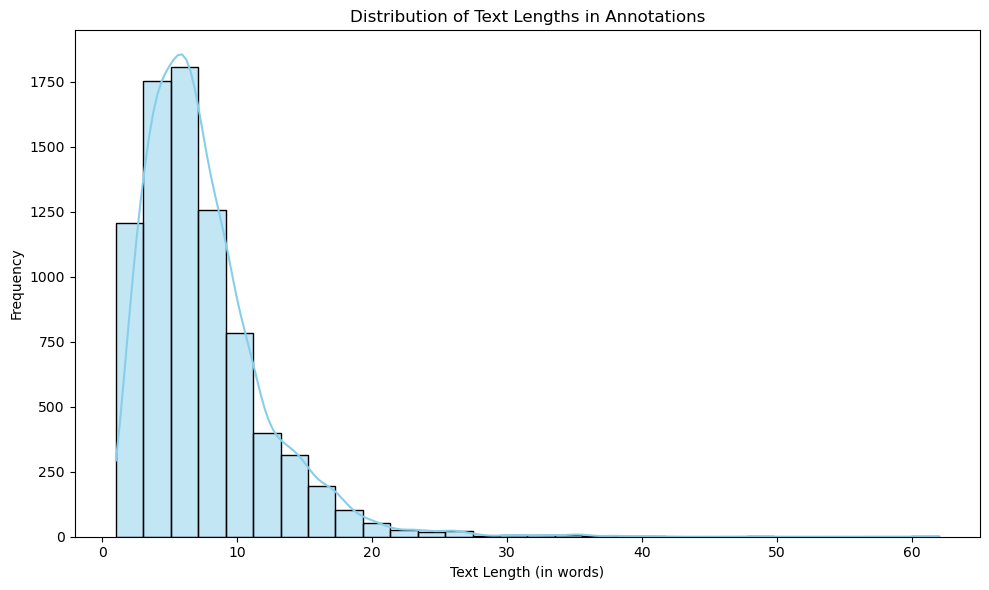

Text length statistics:
count    7975.000000
mean        7.524639
std         4.554947
min         1.000000
25%         4.000000
50%         7.000000
75%         9.000000
max        62.000000
Name: text_length, dtype: float64


In [38]:
#2.b
import matplotlib.pyplot as plt
import seaborn as sns
annotations['text_length'] = annotations['text'].apply(lambda x: len(x.split()))  # Number of words

plt.figure(figsize=(10, 6))
sns.histplot(annotations['text_length'], bins=30, kde=True, color='skyblue', edgecolor='black')

plt.title('Distribution of Text Lengths in Annotations')
plt.xlabel('Text Length (in words)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

text_length_stats = annotations['text_length'].describe()

print(f"Text length statistics:\n{text_length_stats}")

In [16]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from IPython.display import display

#Text Length IQR
annotations['text_length'] = annotations['text'].apply(lambda x: len(x.split()))

Q1 = annotations['text_length'].quantile(0.25)
Q3 = annotations['text_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

text_length_outliers = annotations[(annotations['text_length'] < lower_bound) | (annotations['text_length'] > upper_bound)]

print(f"Average text length: {annotations['text_length'].mean():.2f} words")
print(f"Text length outliers: {len(text_length_outliers)} annotations")

annotations['duration'] = annotations['offset'] - annotations['onset']

#Temporal Errors
temporal_errors = annotations[(annotations['onset'] >= annotations['offset']) | (annotations['duration'] <= 0)]
print(f"Temporal errors (onset >= offset or duration <= 0): {len(temporal_errors)}")

#Zero-Duration Annotations
zero_duration = annotations[annotations['duration'] == 0]
print(f"Annotations with zero duration (onset == offset): {len(zero_duration)}")


# 4. Duration Outliers IQR
duration_outlier_info = []

for file, group in annotations.groupby('filename'):
    durations = group['duration']
    q1 = durations.quantile(0.25)
    q3 = durations.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outliers = group[(group['duration'] < lower) | (group['duration'] > upper)]
    
    duration_outlier_info.append({
        'filename': file,
        'average_duration': durations.mean(),
        'num_outliers': len(outliers),
        'total_annotations': len(group)
    })

duration_outlier_df = pd.DataFrame(duration_outlier_info)

total_duration_outliers = duration_outlier_df['num_outliers'].sum()
print(f"\nTotal duration outliers across all files: {total_duration_outliers}")

# 5. Check for whitespace or empty strings
empty_or_whitespace = annotations[annotations['text'].apply(lambda x: isinstance(x, str) and x.strip() == '')]

print(f"\nAnnotations with empty or whitespace-only text: {len(empty_or_whitespace)}")

Average text length: 7.52 words
Text length outliers: 355 annotations
Temporal errors (onset >= offset or duration <= 0): 0
Annotations with zero duration (onset == offset): 0

Duration Outliers per File (first 5):
     filename  average_duration  num_outliers  total_annotations
0  100388.mp3          3.094185             1                 12
1  100492.mp3         26.390330             0                  1
2  101693.mp3         16.150142             0                  2
3  103192.mp3          5.293133             2                  5
4  104625.mp3          1.275633             2                 32

Total duration outliers across all files: 563

Annotations with empty or whitespace-only text: 0
